In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv('../Data/featured_dataset.csv')

In [2]:
df.head()

,Company,Product,TypeName,Inches,CPU_Frequency (GHz),RAM (GB),Memory Type,Memory Capacity,GPU_Company,GPU_Type,...,Contains_4K,Contains_Quad_HD_plus,CPU_Family,CPU_Generation,CPU_Series,GPU_Family,GPU_Series,GPU_Series_Clean,Series_Type,Performance_Tier
0,Apple,MacBook Pro,Ultrabook,13.3,2.3,8,SSD,128,Intel,Iris Plus Graphics 640,...,0,0,Core,7,i5,Iris,640,640,Numeric,Mid-Range
1,Apple,Macbook Air,Ultrabook,13.3,1.8,8,Flash,128,Intel,HD Graphics 6000,...,0,0,Core,7,i5,HD,6000,6000,Numeric,High-End
2,HP,250 G6,Notebook,15.6,2.5,8,SSD,256,Intel,HD Graphics 620,...,0,0,Core,7,i5,HD,620,620,Numeric,Mid-Range
3,Apple,MacBook Pro,Ultrabook,15.4,2.7,16,SSD,512,AMD,Radeon Pro 455,...,0,0,Core,7,i7,Radeon,455,455,Numeric,Low-End
4,Apple,MacBook Pro,Ultrabook,13.3,3.1,8,SSD,256,Intel,Iris Plus Graphics 650,...,0,0,Core,7,i5,Iris,650,650,Numeric,Mid-Range


In [3]:
df.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'CPU_Frequency (GHz)',
       'RAM (GB)', 'Memory Type', 'Memory Capacity', 'GPU_Company', 'GPU_Type',
       'OpSys', 'Weight (kg)', 'Price (SAR)', 'Resolution_Width',
       'Resolution_Height', 'Contains_HD', 'Contains_IPS',
       'Contains_Touchscreen', 'Contains_4K', 'Contains_Quad_HD_plus',
       'CPU_Family', 'CPU_Generation', 'CPU_Series', 'GPU_Family',
       'GPU_Series', 'GPU_Series_Clean', 'Series_Type', 'Performance_Tier'],
      dtype='object')

In [4]:
target = 'Price (SAR)'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).drop(columns=[target], errors='ignore').columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [5]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(df[categorical_columns]).toarray()

In [6]:
X_combined = pd.concat([
    pd.DataFrame(df[numeric_columns].values, columns=numeric_columns),
    pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))
], axis=1)

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

In [8]:
pca = PCA(n_components=10) 
X_pca = pca.fit_transform(X_scaled)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, df[target], test_size=0.2, random_state=42)

In [10]:
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='MAE', verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 1969.0474152	test: 1931.3214827	best: 1931.3214827 (0)	total: 47.4ms	remaining: 47.3s
100:	learn: 596.0107035	test: 821.8012587	best: 821.8012587 (100)	total: 111ms	remaining: 986ms
200:	learn: 468.8418830	test: 793.1315023	best: 793.1315023 (200)	total: 176ms	remaining: 699ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 786.8935354
bestIteration = 237

Shrink model to first 238 iterations.


In [11]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train R^2 Score: {train_score:.4f}")
print(f"Test R^2 Score: {test_score:.4f}")

Train R^2 Score: 0.9207
Test R^2 Score: 0.8236


In [12]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [13]:
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

In [14]:
train_mae

445.83608793343257

In [15]:
test_mae

786.8935358262885

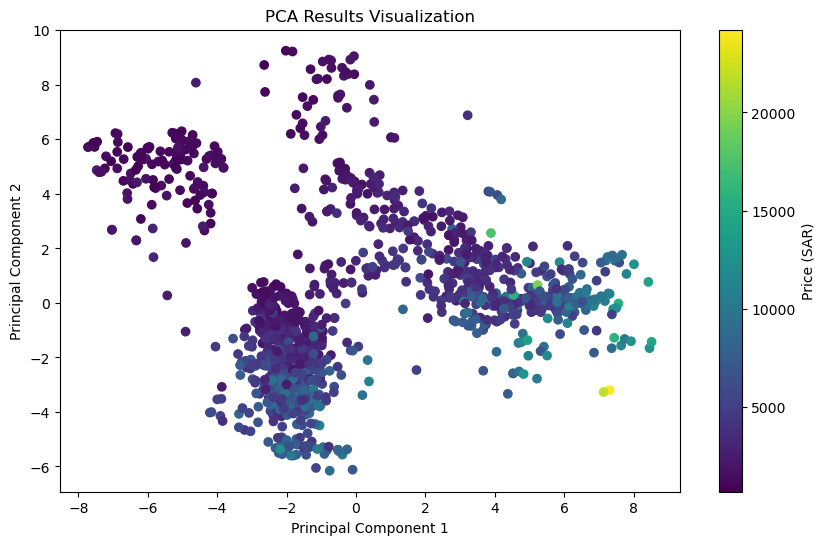

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[target], cmap='viridis')
plt.colorbar(label='Price (SAR)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Results Visualization')
plt.show()

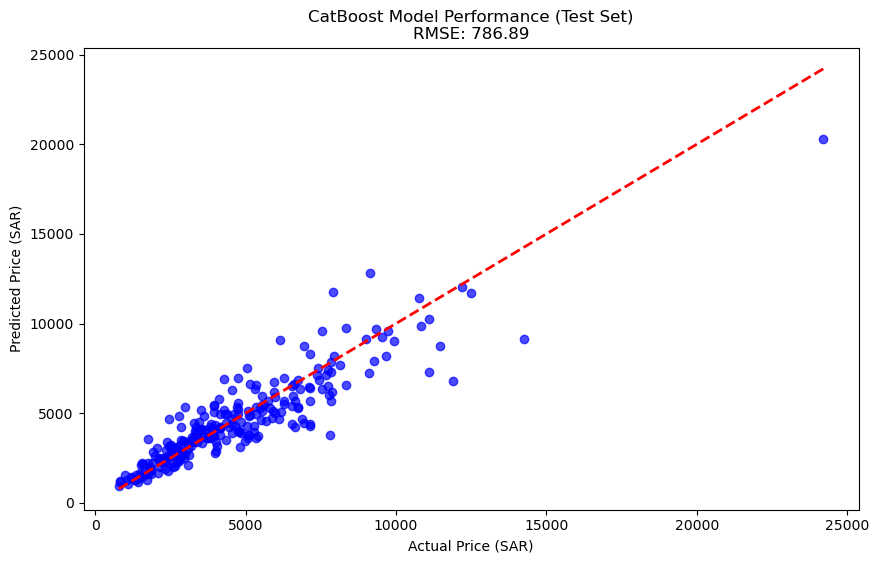

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', lw=2)
plt.xlabel('Actual Price (SAR)')
plt.ylabel('Predicted Price (SAR)')
plt.title(f'CatBoost Model Performance (Test Set)\nMAE: {test_mae:.2f}')
plt.show()